In [10]:
import copy
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import sys
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from typing import List
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [11]:
class DASTModel():
    def __init__(self, train_datasets: List[str], test_dataset: List[str], data_path: str, is_norm: bool, hyper_parameters: dict, model_save_path: str, model_save_name: str) -> None:
        self.TRAIN_DATASETS = train_datasets
        self.TEST_DATASETS = test_dataset
        self.DATA_PATH = data_path
        self.MODEL_SAVE_PATH = model_save_path
        self.MODEL_SAVE_NAME = model_save_name
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.HP = hyper_parameters
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.best_predict = []
        self.last_predict_y = None
        self.train_loss_list = []
        self.test_loss_list = []
        self.best_mse_loss = 10000.0
        self.best_rmse_loss = None
        self.best_train_loss = 10000.0
        self.norm = 'norm' if is_norm else ''
        self.best_model_params = None
        
    @staticmethod
    def RMSE(target, pred):
        square_error = (target - pred) ** 2
        mse =  (torch.sum(square_error)) / len(target)
        rmse = mse ** 0.5
        return rmse
    
    @staticmethod
    def MAE(target, pred):
        absolute_error = np.abs(target - pred)
        return torch.sum(absolute_error) / len(target)
    
    def _load_x_y(self, folder: str):
        y_tmp = np.load(f'{self.DATA_PATH}/{folder}/{folder}_Y.npy')
        feature1 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_2560.npy'))
        feature2 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_1280.npy'))
        feature3 = self._norm(np.load(f'{self.DATA_PATH}/{folder}/{folder}_X_17_640.npy'))
        X_train = np.concatenate((feature1, feature2, feature3), axis=2)
        return X_train, np.reshape(y_tmp, ((len(y_tmp), -1)))
    
    def _norm(self, array):
        min_list = []
        max_list = []
        feat_len = array.shape[2]
        x = array.reshape(-1, feat_len)
        for i in range(feat_len):
            col = x[:, i]
            mi = np.min(col)
            ma = np.max(col)
            min_list.append(mi)
            max_list.append(ma)
        min_array = np.array(min_list)
        max_array = np.array(max_list)
        # print('min=======')
        # print(min_array)
        # print('max=======')
        # print(max_array)
        norm_array = (x - min_array) / (max_array - min_array)
        original_shape_array = norm_array.reshape(-1, 40, feat_len)
        return original_shape_array
        
    def _concate(self):
        self.X_train = np.concatenate(self.X_train, axis=0)
        self.Y_train = np.concatenate(self.Y_train, axis=0)
        self.X_test = np.concatenate(self.X_test, axis=0)
        self.Y_test = np.concatenate(self.Y_test, axis=0)

    def _load_np(self,):
        # train
        for folder in self.TRAIN_DATASETS:
            X_train, Y_train = self._load_x_y(folder)
            # print(X_train.shape)
            # print(X_train[0][0])
            self.X_train.append(X_train)
            self.Y_train.append(Y_train)
        # test
        for folder in self.TEST_DATASETS:
            X_test, Y_test = self._load_x_y(folder)
            self.X_test.append(X_test)
            self.Y_test.append(Y_test)
        
    def _loop_feature(self, X, selected_indices):
        extracted_values_list = []
        for i in range(7):
            for num in selected_indices:
                extracted_values = X[:, :, num + 16 * i]
                extracted_values_list.append(extracted_values)
        result_array = np.stack(extracted_values_list, axis=-1)
        return result_array
    
    def _select_feature(self, selected_indices):
        for i in range(len(self.X_train)):
            self.X_train[i] = self._loop_feature(self.X_train[i], selected_indices)
        for i in range(len(self.X_test)):
            self.X_test[i] = self._loop_feature(self.X_test[i], selected_indices)
        
    def _tensorizing(self):
        self.X_train = Variable(torch.Tensor(self.X_train).float())
        self.Y_train = Variable(torch.Tensor(self.Y_train).float())
        self.X_test = Variable(torch.Tensor(self.X_test).float())
        self.Y_test = Variable(torch.Tensor(self.Y_test).float())
        
    def _get_dataloader(self):
        train_dataset = TensorDataset(self.X_train, self.Y_train)
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        test_dataset = TensorDataset(self.X_test, self.Y_test)
        test_loader = DataLoader(dataset=test_dataset, batch_size=self.HP['batch_size'], shuffle=False)
        return train_loader, test_loader
    
    def _get_model(self):
        model = DAST(self.HP['dim_val_s'], self.HP['dim_attn_s'], self.HP['dim_val_t'], self.HP['dim_attn_t'], self.HP['dim_val'], self.HP['dim_attn'], self.HP['time_step'], self.HP['feature_len'], self.HP['dec_seq_len'], self.HP['output_sequence_length'], self.HP['n_decoder_layers'], self.HP['n_encoder_layers'], self.HP['n_heads'], self.HP['debug'])
        model = model.to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.HP['lr'])
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    def train(self, model: DAST, optimizer: torch.optim.Optimizer, criterion, train_loader: DataLoader, epoch: int):
        model.train()
        tmp_loss_list = []
        loop = tqdm(train_loader, leave=True)
        for _, (X, Y) in enumerate(loop):
            batch_X = X.to(self.device)
            batch_Y = Y.to(self.device)
            out = model(batch_X)
            loss = criterion(out, batch_Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tmp_loss_list.append(loss.item())
        loss_eopch = np.mean(np.array(tmp_loss_list))
        self.train_loss_list.append(loss_eopch)
        if (loss_eopch.item() < self.best_train_loss):
            self.best_train_loss = loss_eopch.item()
        print('epoch = ',epoch,
                'train_loss = ',loss_eopch.item())

    def eval(self, model: DAST, test_loader: DataLoader, criterion, epoch: int):
        model.eval()
        prediction_list = []
        with torch.no_grad():
            for _ ,(batch_x, _) in enumerate(test_loader):
                batch_X = batch_x.to(self.device)
                prediction = model(batch_X)
                prediction_list.append(prediction)

        out_batch_pre = torch.cat(prediction_list).detach().cpu()
        rmse_loss = self.RMSE(self.Y_test, out_batch_pre, )
        mae_loss = self.MAE(self.Y_test, out_batch_pre, )
        test_loss = criterion(out_batch_pre, self.Y_test)
        self.test_loss_list.append(test_loss)
        if (test_loss.item() < self.best_mse_loss):
            self.best_mse_loss = test_loss.item()
            self.best_rmse_loss = rmse_loss.item()
            self.best_predict = np.reshape(out_batch_pre, (-1)).tolist()
            torch.save(model.state_dict(), f'{self.MODEL_SAVE_PATH}/{self.MODEL_SAVE_NAME}.pt')
        print('rmse_loss = ', rmse_loss.item(),
                'mae_loss = ', mae_loss.item(),
                'mse_loss = ', test_loss.item())
        if epoch == self.HP['epochs'] - 1:
            self.last_predict_y = out_batch_pre

    def main(self, selected_indices):
        self._load_np()
        self._select_feature(selected_indices)
        self._concate()
        self._tensorizing()
        model, optimizer, criterion = self._get_model()
        train_loader, test_loader = self._get_dataloader()
        times = 0
        for epoch in range(self.HP['epochs']):
            start = time.time()
            self.train(model, optimizer, criterion, train_loader, epoch)
            end = time.time()
            times += end - start
            self.eval(model, test_loader, criterion, epoch)
        print(f"train time: {times/100:.7f}, s/epoch")
        print(f"embed1: {self.HP['dim_val_s']}, embed2: {self.HP['dim_attn_s']}, lr: {self.HP['lr']}, dec_seq_len: {self.HP['dec_seq_len']}")
        print(f"{self.best_train_loss:.7f}")
        print(f"{self.best_mse_loss:.7f}")
        print(f"{self.best_rmse_loss:.7f}")

In [12]:
selected_indices = [1, 3, 5, 7, 9, 10, 14]
# selected_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
FEATURE_LEN = len(selected_indices)
FEATURE_SIZE = 20
EMBEDD = 20
HYPER_PARAMETERS = {
    'batch_size': 256,
    'dim_val': FEATURE_SIZE,
    'dim_attn': EMBEDD,
    'dim_val_t': FEATURE_SIZE,
    'dim_attn_t': EMBEDD,
    'dim_val_s': FEATURE_SIZE,
    'dim_attn_s': EMBEDD,
    'n_heads': 4,
    'n_decoder_layers': 1,
    'n_encoder_layers': 2,
    'lr': 1e-3,
    'epochs': 100,
    'time_step': 40,
    # limit how many last input used, important!
    'dec_seq_len': 6,
    'output_sequence_length': 1,
    'feature_len': FEATURE_LEN,
    'debug': True
}

In [13]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
# TRAIN_DATASETS = ['Bearing1_1', 'Bearing1_2']
# TEST_DATASET = ['Bearing1_3', 'Bearing1_4', 'Bearing1_5', 'Bearing1_6', 'Bearing1_7']
TRAIN_DATASETS = ['Bearing2_1', 'Bearing2_2']
TEST_DATASET = ['Bearing2_3', 'Bearing2_4', 'Bearing2_5', 'Bearing2_6', 'Bearing2_7']
# TRAIN_DATASETS = ['Bearing3_1', 'Bearing3_2']
# TEST_DATASET = ['Bearing3_3']

MODEL_SAVE_NAME = f'Bearing{TRAIN_DATASETS[0][7]}_pretrain_{len(selected_indices)}_norm'
IS_NORM = True
MODEL_SAVE_PATH = '../../../model/norm'

In [14]:
dast_model = DASTModel(train_datasets=TRAIN_DATASETS, test_dataset=TEST_DATASET, data_path=DATA_PATH, is_norm=IS_NORM, hyper_parameters=HYPER_PARAMETERS, model_save_path=MODEL_SAVE_PATH, model_save_name=MODEL_SAVE_NAME)

In [15]:
dast_model.main(selected_indices)

100%|██████████| 7/7 [00:00<00:00, 12.71it/s]


epoch =  0 train_loss =  0.3974920128073011
rmse_loss =  0.20882174372673035 mae_loss =  0.15648601949214935 mse_loss =  0.04360651969909668


100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


epoch =  1 train_loss =  0.13785082727138484
rmse_loss =  0.3025000989437103 mae_loss =  0.28154072165489197 mse_loss =  0.09150630235671997


100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


epoch =  2 train_loss =  0.08156513961564217
rmse_loss =  0.2779543697834015 mae_loss =  0.1901622861623764 mse_loss =  0.0772586241364479


100%|██████████| 7/7 [00:00<00:00, 13.45it/s]


epoch =  3 train_loss =  0.03332333931965487
rmse_loss =  0.2354898303747177 mae_loss =  0.19381549954414368 mse_loss =  0.05545545741915703


100%|██████████| 7/7 [00:00<00:00, 12.93it/s]


epoch =  4 train_loss =  0.05062993881957872
rmse_loss =  0.23314890265464783 mae_loss =  0.143524169921875 mse_loss =  0.05435841158032417


100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


epoch =  5 train_loss =  0.03653958828986755
rmse_loss =  0.25930413603782654 mae_loss =  0.1631457507610321 mse_loss =  0.06723863631486893


100%|██████████| 7/7 [00:00<00:00, 13.90it/s]


epoch =  6 train_loss =  0.026160080518041338
rmse_loss =  0.24143008887767792 mae_loss =  0.1576777994632721 mse_loss =  0.05828848481178284


100%|██████████| 7/7 [00:00<00:00, 14.40it/s]


epoch =  7 train_loss =  0.03172360347317798
rmse_loss =  0.26697462797164917 mae_loss =  0.17175760865211487 mse_loss =  0.07127545028924942


100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


epoch =  8 train_loss =  0.025106652806113874
rmse_loss =  0.2537274658679962 mae_loss =  0.16524125635623932 mse_loss =  0.06437762081623077


100%|██████████| 7/7 [00:00<00:00, 13.38it/s]


epoch =  9 train_loss =  0.02687769416453583
rmse_loss =  0.26135343313217163 mae_loss =  0.1691945344209671 mse_loss =  0.0683056190609932


100%|██████████| 7/7 [00:00<00:00, 13.15it/s]


epoch =  10 train_loss =  0.024691882709573423
rmse_loss =  0.2585848271846771 mae_loss =  0.1703372299671173 mse_loss =  0.06686610728502274


100%|██████████| 7/7 [00:00<00:00, 12.63it/s]


epoch =  11 train_loss =  0.024933310092559884
rmse_loss =  0.26140615344047546 mae_loss =  0.17246092855930328 mse_loss =  0.06833317875862122


100%|██████████| 7/7 [00:00<00:00, 13.37it/s]


epoch =  12 train_loss =  0.023940288594790866
rmse_loss =  0.2618336081504822 mae_loss =  0.17425519227981567 mse_loss =  0.06855683773756027


100%|██████████| 7/7 [00:00<00:00, 12.70it/s]


epoch =  13 train_loss =  0.02384981363346534
rmse_loss =  0.2644875943660736 mae_loss =  0.17631949484348297 mse_loss =  0.06995368003845215


100%|██████████| 7/7 [00:00<00:00, 13.57it/s]


epoch =  14 train_loss =  0.023157456257779683
rmse_loss =  0.26551270484924316 mae_loss =  0.17826656997203827 mse_loss =  0.07049699872732162


100%|██████████| 7/7 [00:00<00:00, 13.33it/s]


epoch =  15 train_loss =  0.023010546008923223
rmse_loss =  0.267842173576355 mae_loss =  0.18029513955116272 mse_loss =  0.07173943519592285


100%|██████████| 7/7 [00:00<00:00, 13.72it/s]


epoch =  16 train_loss =  0.02248835813121072
rmse_loss =  0.2687224745750427 mae_loss =  0.18221986293792725 mse_loss =  0.07221176475286484


100%|██████████| 7/7 [00:00<00:00, 13.24it/s]


epoch =  17 train_loss =  0.022295597441760556
rmse_loss =  0.27044209837913513 mae_loss =  0.18407584726810455 mse_loss =  0.07313892245292664


100%|██████████| 7/7 [00:00<00:00, 13.58it/s]


epoch =  18 train_loss =  0.021926381758281162
rmse_loss =  0.27140066027641296 mae_loss =  0.1859043836593628 mse_loss =  0.07365832477807999


100%|██████████| 7/7 [00:00<00:00, 12.66it/s]


epoch =  19 train_loss =  0.02167871594429016
rmse_loss =  0.272619366645813 mae_loss =  0.1875796616077423 mse_loss =  0.07432132214307785


100%|██████████| 7/7 [00:00<00:00, 13.23it/s]


epoch =  20 train_loss =  0.021426586667075753
rmse_loss =  0.27361631393432617 mae_loss =  0.18918950855731964 mse_loss =  0.07486588507890701


100%|██████████| 7/7 [00:00<00:00, 13.26it/s]


epoch =  21 train_loss =  0.02117215609177947
rmse_loss =  0.27444347739219666 mae_loss =  0.1906781643629074 mse_loss =  0.07531922310590744


100%|██████████| 7/7 [00:00<00:00, 14.31it/s]


epoch =  22 train_loss =  0.020970256932611977
rmse_loss =  0.2752153277397156 mae_loss =  0.19204387068748474 mse_loss =  0.07574347406625748


100%|██████████| 7/7 [00:00<00:00, 14.76it/s]


epoch =  23 train_loss =  0.02076299668156675
rmse_loss =  0.2758350670337677 mae_loss =  0.19336697459220886 mse_loss =  0.07608498632907867


100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


epoch =  24 train_loss =  0.020577763307041357
rmse_loss =  0.2763880491256714 mae_loss =  0.1945883184671402 mse_loss =  0.0763903483748436


100%|██████████| 7/7 [00:00<00:00, 13.22it/s]


epoch =  25 train_loss =  0.020412295923701355
rmse_loss =  0.27687960863113403 mae_loss =  0.1957298219203949 mse_loss =  0.07666230946779251


100%|██████████| 7/7 [00:00<00:00, 13.46it/s]


epoch =  26 train_loss =  0.02025090004982693
rmse_loss =  0.27728888392448425 mae_loss =  0.19680160284042358 mse_loss =  0.07688912004232407


100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


epoch =  27 train_loss =  0.020101639941068634
rmse_loss =  0.2776130139827728 mae_loss =  0.19773955643177032 mse_loss =  0.077068991959095


100%|██████████| 7/7 [00:00<00:00, 13.88it/s]


epoch =  28 train_loss =  0.019962486045967256
rmse_loss =  0.27785196900367737 mae_loss =  0.19854767620563507 mse_loss =  0.077201709151268


100%|██████████| 7/7 [00:00<00:00, 13.84it/s]


epoch =  29 train_loss =  0.01982701975586159
rmse_loss =  0.27800512313842773 mae_loss =  0.19921644032001495 mse_loss =  0.07728684693574905


100%|██████████| 7/7 [00:00<00:00, 13.67it/s]


epoch =  30 train_loss =  0.01969447871670127
rmse_loss =  0.2780647575855255 mae_loss =  0.19972087442874908 mse_loss =  0.07732000946998596


100%|██████████| 7/7 [00:00<00:00, 12.72it/s]


epoch =  31 train_loss =  0.019562145695090294
rmse_loss =  0.27801936864852905 mae_loss =  0.20004843175411224 mse_loss =  0.07729477435350418


100%|██████████| 7/7 [00:00<00:00, 13.16it/s]


epoch =  32 train_loss =  0.019424048119357655
rmse_loss =  0.2778514325618744 mae_loss =  0.20017993450164795 mse_loss =  0.07720142602920532


100%|██████████| 7/7 [00:00<00:00, 13.33it/s]


epoch =  33 train_loss =  0.019274111670841063
rmse_loss =  0.2775397300720215 mae_loss =  0.20008742809295654 mse_loss =  0.0770282968878746


100%|██████████| 7/7 [00:00<00:00, 13.23it/s]


epoch =  34 train_loss =  0.01910477171518973
rmse_loss =  0.27707284688949585 mae_loss =  0.19976238906383514 mse_loss =  0.07676935940980911


100%|██████████| 7/7 [00:00<00:00, 13.16it/s]


epoch =  35 train_loss =  0.018906453424798592
rmse_loss =  0.27646365761756897 mae_loss =  0.19921576976776123 mse_loss =  0.07643215358257294


100%|██████████| 7/7 [00:00<00:00, 13.56it/s]


epoch =  36 train_loss =  0.018673415295779705
rmse_loss =  0.2757461369037628 mae_loss =  0.1984647661447525 mse_loss =  0.07603592425584793


100%|██████████| 7/7 [00:00<00:00, 12.97it/s]


epoch =  37 train_loss =  0.018407593614288738
rmse_loss =  0.27491259574890137 mae_loss =  0.19747993350028992 mse_loss =  0.07557693868875504


100%|██████████| 7/7 [00:00<00:00, 13.05it/s]


epoch =  38 train_loss =  0.018046881471361433
rmse_loss =  0.27404165267944336 mae_loss =  0.19654564559459686 mse_loss =  0.07509883493185043


100%|██████████| 7/7 [00:00<00:00, 13.08it/s]


epoch =  39 train_loss =  0.017422021233609745
rmse_loss =  0.27374759316444397 mae_loss =  0.19665972888469696 mse_loss =  0.07493774592876434


100%|██████████| 7/7 [00:00<00:00, 12.89it/s]


epoch =  40 train_loss =  0.016648946097120643
rmse_loss =  0.27413415908813477 mae_loss =  0.19771400094032288 mse_loss =  0.0751495435833931


100%|██████████| 7/7 [00:00<00:00, 13.71it/s]


epoch =  41 train_loss =  0.016031487046607902
rmse_loss =  0.2742385268211365 mae_loss =  0.1984729766845703 mse_loss =  0.07520677149295807


100%|██████████| 7/7 [00:00<00:00, 13.47it/s]


epoch =  42 train_loss =  0.015226803520428283
rmse_loss =  0.27530214190483093 mae_loss =  0.2006244659423828 mse_loss =  0.07579126209020615


100%|██████████| 7/7 [00:00<00:00, 12.98it/s]


epoch =  43 train_loss =  0.014466488966718316
rmse_loss =  0.27657434344291687 mae_loss =  0.2026563435792923 mse_loss =  0.07649337500333786


100%|██████████| 7/7 [00:00<00:00, 12.23it/s]


epoch =  44 train_loss =  0.013922734119530236
rmse_loss =  0.27743083238601685 mae_loss =  0.2041051685810089 mse_loss =  0.07696787267923355


100%|██████████| 7/7 [00:00<00:00, 12.96it/s]


epoch =  45 train_loss =  0.014900664699130825
rmse_loss =  0.27979159355163574 mae_loss =  0.2059413194656372 mse_loss =  0.07828333973884583


100%|██████████| 7/7 [00:00<00:00, 13.25it/s]


epoch =  46 train_loss =  0.018293239575411593
rmse_loss =  0.2645531892776489 mae_loss =  0.18549208343029022 mse_loss =  0.06998839229345322


100%|██████████| 7/7 [00:00<00:00, 13.09it/s]


epoch =  47 train_loss =  0.015794074894594296
rmse_loss =  0.2681088447570801 mae_loss =  0.19696924090385437 mse_loss =  0.07188235223293304


100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


epoch =  48 train_loss =  0.011390444174009775
rmse_loss =  0.27606576681137085 mae_loss =  0.19879700243473053 mse_loss =  0.07621230185031891


100%|██████████| 7/7 [00:00<00:00, 13.52it/s]


epoch =  49 train_loss =  0.010816614708996244
rmse_loss =  0.2784597873687744 mae_loss =  0.20265455543994904 mse_loss =  0.0775398463010788


100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


epoch =  50 train_loss =  0.012358141314637448
rmse_loss =  0.269768089056015 mae_loss =  0.18970884382724762 mse_loss =  0.07277482002973557


100%|██████████| 7/7 [00:00<00:00, 13.05it/s]


epoch =  51 train_loss =  0.011600253970495291
rmse_loss =  0.2628026306629181 mae_loss =  0.18513640761375427 mse_loss =  0.06906522810459137


100%|██████████| 7/7 [00:00<00:00, 12.99it/s]


epoch =  52 train_loss =  0.010247390185083662
rmse_loss =  0.2894240915775299 mae_loss =  0.2273809313774109 mse_loss =  0.08376631140708923


100%|██████████| 7/7 [00:00<00:00, 12.73it/s]


epoch =  53 train_loss =  0.014397033689809697
rmse_loss =  0.27964335680007935 mae_loss =  0.20138093829154968 mse_loss =  0.07820039987564087


100%|██████████| 7/7 [00:00<00:00, 13.70it/s]


epoch =  54 train_loss =  0.01695136759164078
rmse_loss =  0.2563265860080719 mae_loss =  0.17469719052314758 mse_loss =  0.06570331752300262


100%|██████████| 7/7 [00:00<00:00, 13.66it/s]


epoch =  55 train_loss =  0.011041957510834826
rmse_loss =  0.26161909103393555 mae_loss =  0.1847713142633438 mse_loss =  0.06844454258680344


100%|██████████| 7/7 [00:00<00:00, 13.92it/s]


epoch =  56 train_loss =  0.011688292192827378
rmse_loss =  0.2982388138771057 mae_loss =  0.23698802292346954 mse_loss =  0.0889463946223259


100%|██████████| 7/7 [00:00<00:00, 13.98it/s]


epoch =  57 train_loss =  0.019183868542313576
rmse_loss =  0.2877725064754486 mae_loss =  0.21299950778484344 mse_loss =  0.08281301707029343


100%|██████████| 7/7 [00:00<00:00, 14.26it/s]


epoch =  58 train_loss =  0.025558770102049624
rmse_loss =  0.25382307171821594 mae_loss =  0.17417748272418976 mse_loss =  0.06442614644765854


100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


epoch =  59 train_loss =  0.020023104352211312
rmse_loss =  0.2733779549598694 mae_loss =  0.23441386222839355 mse_loss =  0.07473549991846085


100%|██████████| 7/7 [00:00<00:00, 14.04it/s]


epoch =  60 train_loss =  0.02777582416976137
rmse_loss =  0.2999626100063324 mae_loss =  0.209020733833313 mse_loss =  0.08997756242752075


100%|██████████| 7/7 [00:00<00:00, 14.29it/s]


epoch =  61 train_loss =  0.025609341450035572
rmse_loss =  0.3094967007637024 mae_loss =  0.22216975688934326 mse_loss =  0.09578820317983627


100%|██████████| 7/7 [00:00<00:00, 13.36it/s]


epoch =  62 train_loss =  0.027038506365248134
rmse_loss =  0.2734724283218384 mae_loss =  0.2180124819278717 mse_loss =  0.07478717714548111


100%|██████████| 7/7 [00:00<00:00, 14.11it/s]


epoch =  63 train_loss =  0.024661609287639812
rmse_loss =  0.2480478733778 mae_loss =  0.17675073444843292 mse_loss =  0.06152774393558502


100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


epoch =  64 train_loss =  0.01706607360392809
rmse_loss =  0.2720380127429962 mae_loss =  0.18826837837696075 mse_loss =  0.07400467991828918


100%|██████████| 7/7 [00:00<00:00, 13.40it/s]


epoch =  65 train_loss =  0.01390551236857261
rmse_loss =  0.28396913409233093 mae_loss =  0.2018996626138687 mse_loss =  0.08063847571611404


100%|██████████| 7/7 [00:00<00:00, 13.94it/s]


epoch =  66 train_loss =  0.010547395230137877
rmse_loss =  0.27466079592704773 mae_loss =  0.2081647366285324 mse_loss =  0.07543855905532837


100%|██████████| 7/7 [00:00<00:00, 13.24it/s]


epoch =  67 train_loss =  0.011079496537734355
rmse_loss =  0.2717694938182831 mae_loss =  0.19472363591194153 mse_loss =  0.07385866343975067


100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


epoch =  68 train_loss =  0.009877825954130717
rmse_loss =  0.27603211998939514 mae_loss =  0.19759254157543182 mse_loss =  0.07619373500347137


100%|██████████| 7/7 [00:00<00:00, 14.30it/s]


epoch =  69 train_loss =  0.010253565851598978
rmse_loss =  0.2866722047328949 mae_loss =  0.22844555974006653 mse_loss =  0.08218095451593399


100%|██████████| 7/7 [00:00<00:00, 13.42it/s]


epoch =  70 train_loss =  0.011620284390768834
rmse_loss =  0.2735121250152588 mae_loss =  0.19227004051208496 mse_loss =  0.07480888813734055


100%|██████████| 7/7 [00:00<00:00, 13.50it/s]


epoch =  71 train_loss =  0.010178692638874054
rmse_loss =  0.2728547155857086 mae_loss =  0.1926177591085434 mse_loss =  0.07444969564676285


100%|██████████| 7/7 [00:00<00:00, 13.68it/s]


epoch =  72 train_loss =  0.010393052910720664
rmse_loss =  0.27901491522789 mae_loss =  0.22123484313488007 mse_loss =  0.07784932851791382


100%|██████████| 7/7 [00:00<00:00, 13.69it/s]


epoch =  73 train_loss =  0.012306682299822569
rmse_loss =  0.2779786288738251 mae_loss =  0.19301338493824005 mse_loss =  0.07727212458848953


100%|██████████| 7/7 [00:00<00:00, 13.74it/s]


epoch =  74 train_loss =  0.011706408179764236
rmse_loss =  0.27225974202156067 mae_loss =  0.19135306775569916 mse_loss =  0.07412536442279816


100%|██████████| 7/7 [00:00<00:00, 13.34it/s]


epoch =  75 train_loss =  0.012732491720401282
rmse_loss =  0.27474063634872437 mae_loss =  0.2216113954782486 mse_loss =  0.07548241317272186


100%|██████████| 7/7 [00:00<00:00, 13.41it/s]


epoch =  76 train_loss =  0.01401973721970405
rmse_loss =  0.27980637550354004 mae_loss =  0.1950499415397644 mse_loss =  0.07829160988330841


100%|██████████| 7/7 [00:00<00:00, 13.05it/s]


epoch =  77 train_loss =  0.013607157128197806
rmse_loss =  0.2750749886035919 mae_loss =  0.19465428590774536 mse_loss =  0.07566624134778976


100%|██████████| 7/7 [00:00<00:00, 14.15it/s]


epoch =  78 train_loss =  0.012600746937096119
rmse_loss =  0.2710351347923279 mae_loss =  0.2185857594013214 mse_loss =  0.07346004247665405


100%|██████████| 7/7 [00:00<00:00, 13.48it/s]


epoch =  79 train_loss =  0.013551243414570178
rmse_loss =  0.2761547565460205 mae_loss =  0.1947198212146759 mse_loss =  0.07626144587993622


100%|██████████| 7/7 [00:00<00:00, 12.90it/s]


epoch =  80 train_loss =  0.012528836061911923
rmse_loss =  0.2783518433570862 mae_loss =  0.19779565930366516 mse_loss =  0.07747974991798401


100%|██████████| 7/7 [00:00<00:00, 13.22it/s]


epoch =  81 train_loss =  0.011250337735483689
rmse_loss =  0.27346205711364746 mae_loss =  0.21983812749385834 mse_loss =  0.07478149235248566


100%|██████████| 7/7 [00:00<00:00, 12.91it/s]


epoch =  82 train_loss =  0.013402048298822982
rmse_loss =  0.2722904086112976 mae_loss =  0.1902555227279663 mse_loss =  0.07414206117391586


100%|██████████| 7/7 [00:00<00:00, 13.10it/s]


epoch =  83 train_loss =  0.011291136965155602
rmse_loss =  0.27756962180137634 mae_loss =  0.1963231861591339 mse_loss =  0.07704488933086395


100%|██████████| 7/7 [00:00<00:00, 13.64it/s]


epoch =  84 train_loss =  0.010056634965751852
rmse_loss =  0.27498942613601685 mae_loss =  0.21811401844024658 mse_loss =  0.0756191834807396


100%|██████████| 7/7 [00:00<00:00, 13.89it/s]


epoch =  85 train_loss =  0.011665674092780267
rmse_loss =  0.2727780044078827 mae_loss =  0.1886521428823471 mse_loss =  0.07440784573554993


100%|██████████| 7/7 [00:00<00:00, 13.19it/s]


epoch =  86 train_loss =  0.010195968805679254
rmse_loss =  0.27486929297447205 mae_loss =  0.19299326837062836 mse_loss =  0.07555312663316727


100%|██████████| 7/7 [00:00<00:00, 13.39it/s]


epoch =  87 train_loss =  0.009732389498302447
rmse_loss =  0.26927340030670166 mae_loss =  0.20906279981136322 mse_loss =  0.07250817120075226


100%|██████████| 7/7 [00:00<00:00, 12.39it/s]


epoch =  88 train_loss =  0.010997900240389364
rmse_loss =  0.2731451094150543 mae_loss =  0.18824900686740875 mse_loss =  0.07460825890302658


100%|██████████| 7/7 [00:00<00:00, 11.75it/s]


epoch =  89 train_loss =  0.009718632558360696
rmse_loss =  0.2775229811668396 mae_loss =  0.19600854814052582 mse_loss =  0.07701900601387024


100%|██████████| 7/7 [00:00<00:00, 12.60it/s]


epoch =  90 train_loss =  0.008718785497226886
rmse_loss =  0.26512381434440613 mae_loss =  0.19739887118339539 mse_loss =  0.07029063999652863


100%|██████████| 7/7 [00:00<00:00, 12.95it/s]


epoch =  91 train_loss =  0.008687897086409586
rmse_loss =  0.2693803310394287 mae_loss =  0.1854744851589203 mse_loss =  0.07256575673818588


100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


epoch =  92 train_loss =  0.00811399657478822
rmse_loss =  0.27553847432136536 mae_loss =  0.1951388269662857 mse_loss =  0.0759214460849762


100%|██████████| 7/7 [00:00<00:00, 12.57it/s]


epoch =  93 train_loss =  0.007986115000676364
rmse_loss =  0.26593777537345886 mae_loss =  0.19054366648197174 mse_loss =  0.07072289288043976


100%|██████████| 7/7 [00:00<00:00, 12.51it/s]


epoch =  94 train_loss =  0.0076087243921522585
rmse_loss =  0.27146947383880615 mae_loss =  0.1863795816898346 mse_loss =  0.07369568198919296


100%|██████████| 7/7 [00:00<00:00, 13.10it/s]


epoch =  95 train_loss =  0.007566073177648442
rmse_loss =  0.27318188548088074 mae_loss =  0.1920238584280014 mse_loss =  0.07462834566831589


100%|██████████| 7/7 [00:00<00:00, 13.65it/s]


epoch =  96 train_loss =  0.007638710492756218
rmse_loss =  0.2672683894634247 mae_loss =  0.19036394357681274 mse_loss =  0.07143238931894302


100%|██████████| 7/7 [00:00<00:00, 13.06it/s]


epoch =  97 train_loss =  0.007444842718541622
rmse_loss =  0.27325958013534546 mae_loss =  0.1856725513935089 mse_loss =  0.07467079162597656


100%|██████████| 7/7 [00:00<00:00, 12.69it/s]


epoch =  98 train_loss =  0.007613642573622721
rmse_loss =  0.27141520380973816 mae_loss =  0.19073040783405304 mse_loss =  0.07366620749235153


100%|██████████| 7/7 [00:00<00:00, 13.16it/s]


epoch =  99 train_loss =  0.007867254067345389
rmse_loss =  0.2667704224586487 mae_loss =  0.19014784693717957 mse_loss =  0.07116646319627762
train time: 0.5305631, s/epoch
embed1: 20, embed2: 20, lr: 0.001, dec_seq_len: 6
0.0074448
0.0436065
0.2088217


In [16]:
y = dast_model.Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

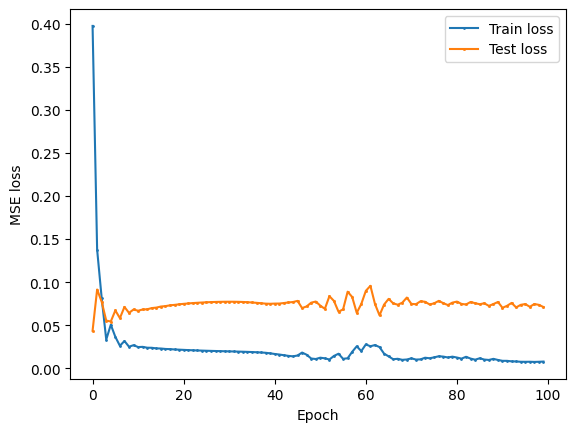

In [17]:
def loss_list():
    plt.plot(dast_model.train_loss_list, label='Train loss', marker='o', markersize=1)
    plt.plot(dast_model.test_loss_list, label='Test loss', marker='s', markersize=1)
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.legend()
    plt.show()
loss_list()

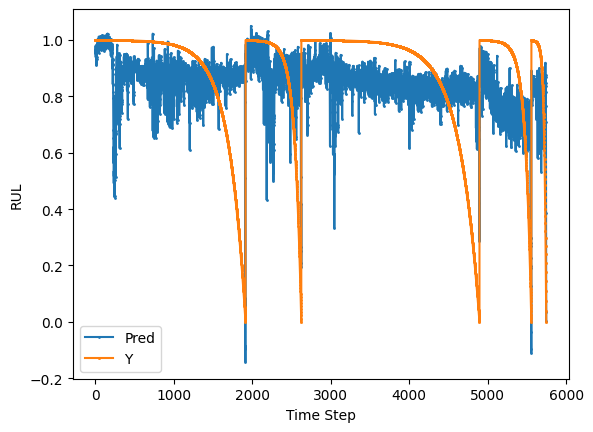

In [18]:
def best_predict():
    plt.plot(dast_model.best_predict, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
best_predict()

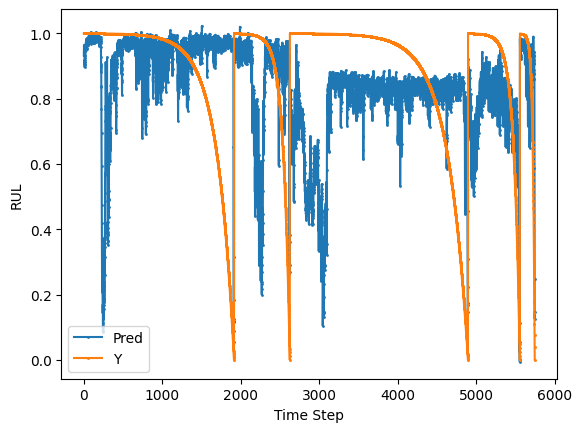

In [19]:
def last_predict_vs_y():
    last_predict_y = np.reshape(dast_model.last_predict_y, (-1))
    last_predict_y = last_predict_y.tolist()
    plt.plot(last_predict_y, label='Pred', marker='o', markersize=1)
    plt.plot(y, label='Y', marker='s', markersize=1)
    plt.xlabel('Time Step')
    plt.ylabel('RUL')
    plt.legend()
    plt.show()
last_predict_vs_y()

In [11]:
print(f"{dast_model.best_train_loss:.7f}")
print(f"{dast_model.best_mse_loss:.7f}")
print(f"{dast_model.best_rmse_loss:.7f}")

0.0095894
0.0499251
0.2234393


In [ ]:
# Run above